In [1]:
import numpy as np

from matplotlib import pyplot as plt

from snn.graphs import plot_network
from snn.resonator import create_excitatory_resonator, create_excitatory_inhibitory_resonator, test_resonator_on_chirp


In [2]:
from utils import copy_filter_hp_to_other_clock_frequency

# copy_filter_hp_to_other_clock_frequency(1536000, 15360)

In [55]:
def resonator_output_spikes_on_chirp(
        freq0,
        clk_freq,
        save_figure=False,
        neurons_log_potentials=None,
        neurons_log_spikes=None,
        step=None,
):
    my_resonator = trained_resonator(
        freq0=float(freq0),
        filters_folder='filters4_xi0'
    )
    neurons_log_potentials = neurons_log_potentials or []
    for i in neurons_log_potentials:
        my_resonator.log_membrane_potential(i)

    neurons_log_spikes = neurons_log_spikes or []
    for i in neurons_log_spikes:
        my_resonator.log_out_spikes(i)

    start_freq = 0
    spectrum = 2 * float(freq0)
    step = step or 1/clk_freq
    test_size = int(spectrum / step)

    test_resonator_on_chirp(
        my_resonator,
        start_freq=start_freq,
        step=step,
        test_size=test_size,
        clk_freq=clk_freq
    )

    for i in neurons_log_potentials:
        membrane_neuron = my_resonator.neurons[i]
        y_membrane = membrane_neuron.membrane_potential_graph()
        x = np.linspace(start_freq, start_freq + spectrum, len(y_membrane))
        plt.title(f'membrane potential f={freq0}, neuron={i}')
        plt.plot(x, y_membrane)
        plt.show()

    spikes_window_size = 500
    for i in neurons_log_spikes:
        spikes_neuron = my_resonator.neurons[i]
        y_events = spikes_neuron.out_spikes()
        y_spikes = np.zeros(y_events[-1] + 1)
        y_spikes[y_events] = 1
        y_spikes = np.convolve(y_spikes, np.ones(spikes_window_size, dtype=int), 'valid')
        x = np.linspace(start_freq, start_freq + spectrum, len(y_spikes))
        plt.title(f'spikes in window of {spikes_window_size} freq: {freq0}')
        if save_figure:
            plt.savefig('plot.png', dpi=300, bbox_inches='tight')
            plt.close()
        else:
            plt.plot(x, y_spikes)
            plt.show()

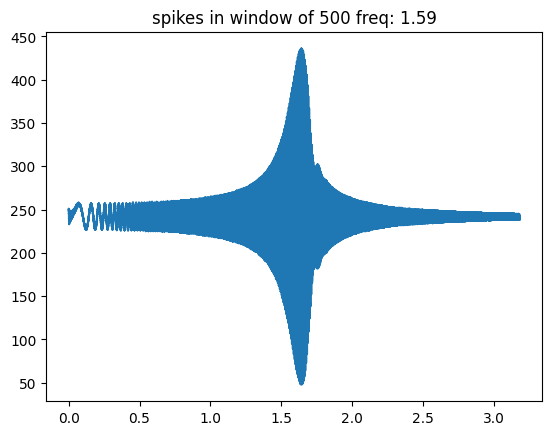

In [56]:
resonator_output_spikes_on_chirp(freq0=1.59, clk_freq=15360, step=1/1536000, neurons_log_spikes=[-1])

In [162]:
from snn.resonator import trained_resonator

def plot_resonator_on_freq(signal_freq, clk_freq, resonator_freq, phases=20, show=True, weights=None, neurons_log_spikes=None, noise_std=0):
    my_resonator = trained_resonator(
        freq0=float(resonator_freq),
        filters_folder='filters4_xi0'
    )
    neurons_log_spikes = neurons_log_spikes or []
    for i in neurons_log_spikes:
        my_resonator.log_out_spikes(i)

    if type(signal_freq) is not list:
        signal_freq = [signal_freq]

    weights = weights or np.ones(len(signal_freq))

    x = np.linspace(0, phases / resonator_freq, int(phases * clk_freq / resonator_freq))
    t = x * 2 * np.pi * signal_freq[0]
    sine_wave = np.sin(t) * weights[0]
    for w, f in zip(weights[1:], signal_freq[1:]):
        t = x * 2 * np.pi * f
        sine_wave += np.sin(t) * w
    sine_wave += np.random.normal(0, noise_std, len(sine_wave))
    sine_wave /= np.max(sine_wave)

    my_resonator.input_full_data(sine_wave)
    spikes_window_size = 500

    for i in neurons_log_spikes:
        output_neuron = my_resonator.neurons[i]
        y_events = output_neuron.out_spikes()
        y_spikes = np.zeros(y_events[-1] + 1)
        y_spikes[y_events] = 1
        y_spikes = np.convolve(y_spikes, np.ones(spikes_window_size, dtype=int), 'valid')
        plt.title(f'signal freq {signal_freq}')
        plt.plot(np.linspace(0, phases, len(y_spikes)), y_spikes, label=signal_freq)

    if show:
        plt.show()

    return my_resonator

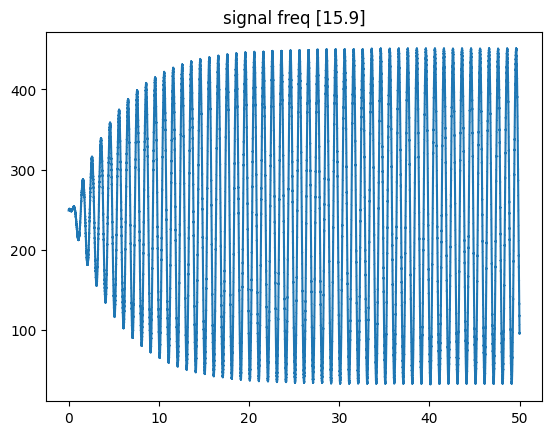

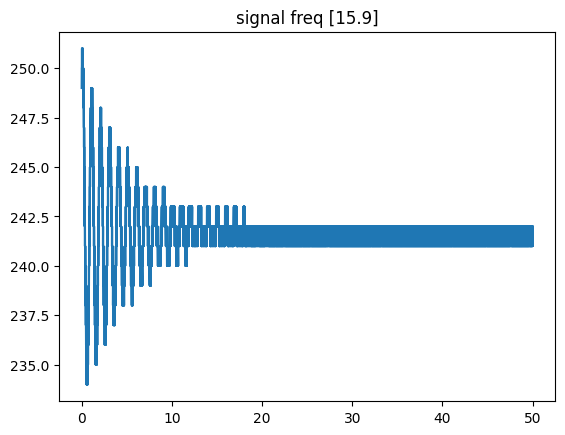

In [144]:
plot_resonator_on_freq(15.9, clk_freq=153600, resonator_freq=15.9, show=True, neurons_log_spikes=[-1], phases=50)
# plot_resonator_on_freq(1.59, clk_freq=15360, resonator_freq=1.59, show=True, neurons_log_spikes=[-1], phases=50)
# plot_resonator_on_freq(15.9, clk_freq=15360, resonator_freq=1.59, show=True, neurons_log_spikes=[-1], phases=50)
plot_resonator_on_freq(15.9, clk_freq=15360, resonator_freq=1.59, show=True, neurons_log_spikes=[-1], phases=50)
# plot_resonator_on_freq(32, clk_freq=153600, resonator_freq=15.9, show=True, neurons_log_spikes=[-1], phases=50)

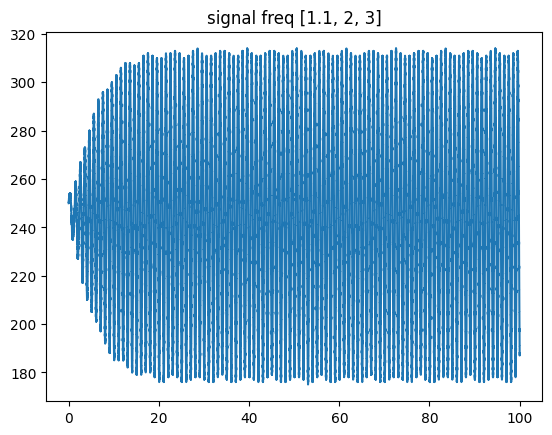

In [149]:
plot_resonator_on_freq([1.1, 2, 3], clk_freq=15360, resonator_freq=1.1, show=True, neurons_log_spikes=[-1], phases=100)
# plot_resonator_on_freq(3.2, clk_freq=153600, resonator_freq=1.6, show=True, neurons_log_spikes=[-1], phases=15)
# plot_resonator_on_freq(1.75/2, clk_freq=1536000, resonator_freq=1.75, show=True, neurons_log_spikes=[-1], duration=7)

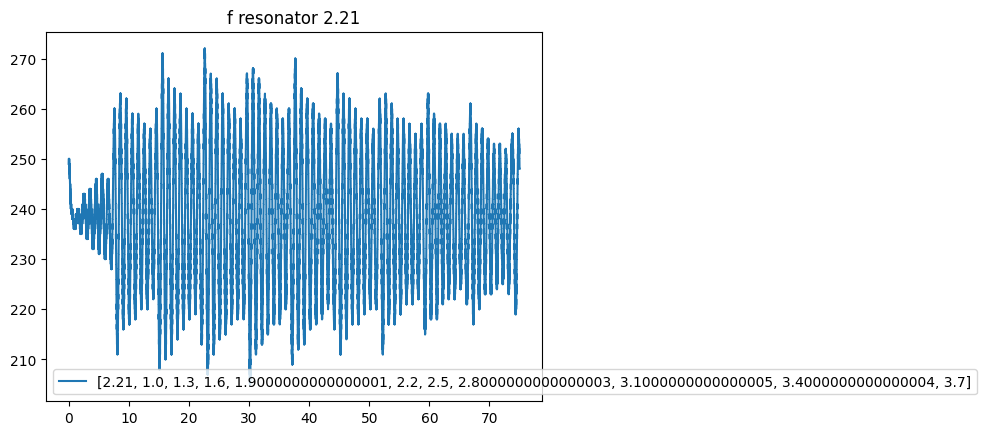

In [163]:
resonators_frequencies = [2.21]
for f_resonator in resonators_frequencies:
    if f_resonator > 10:
        amp = 10
    else:
        amp = 1
    noise_freqs = [2.21] + np.arange(1, 4, .3).tolist()
    # noise_freqs[0] = f_resonator
    plot_resonator_on_freq(noise_freqs, weights=[.5] + [.5]*(len(noise_freqs) - 1 ),
                           clk_freq=15360 * amp, resonator_freq=f_resonator, show=False, neurons_log_spikes=[-1],
                           phases=75, noise_std=1)
    plt.legend()
    plt.title(f'f resonator {f_resonator}')
    plt.show()

## Depict Phase Shifting

In [5]:
from snn.graphs import plot_network
from snn.resonator import create_excitatory_inhibitory_resonator, create_excitatory_resonator

my_resonator = create_excitatory_resonator(freq0=104, clk_freq=1536000)
# my_resonator = create_excitatory_resonator(freq0='5.900', clk_freq=76800)
plot_network(my_resonator)

FileNotFoundError: [Errno 2] No such file or directory: '../filters2/clk_1536000/parameters/f_104.json'

In [7]:
from snn.resonator import create_base_resonator, simple_resonator

clk_freq = 1536000
resonator_freq = 212
duration = 1.5

resonator0 = simple_resonator(freq0=resonator_freq, clk_freq=clk_freq, lf=4,
                              thetas=[-9.896, -21.483, -20.349, -20.591],
                              weights=[34.091, 53.846, 42.951, 40.759, 41.223])
resonator0.amplitude[0] = 10_000.0
resonator0.log_out_spikes(0)

# my_resonator = create_base_resonator(freq0=resonator_freq, clk_freq=clk_freq)
my_resonator = simple_resonator(freq0=resonator_freq, clk_freq=clk_freq, lf=4,
                              thetas=[-9.896, -21.483, -20.349, -20.591],
                              weights=[53.846, 34.091, 42.951, 40.759, 41.223])

signal_freq = 212

neurons_log_spikes = range(5)
for i in neurons_log_spikes:
    my_resonator.log_out_spikes(i)

spectrum = duration

x = np.linspace(0, spectrum, int(duration * clk_freq))
t = x * 2 * np.pi * signal_freq
sine_wave = np.sin(t)

# my_resonator.input_full_data(np.zeros(clk_freq * 5))
# for i in neurons_log_spikes:
#     output_neuron = my_resonator.neurons[i]
#     output_neuron.forget_logs()
my_resonator.input_full_data(sine_wave)
resonator0.input_full_data(sine_wave)
None

<string>:3: NumbaTypeSafetyWarning: unsafe cast from int64 to int32. Precision may be lost.


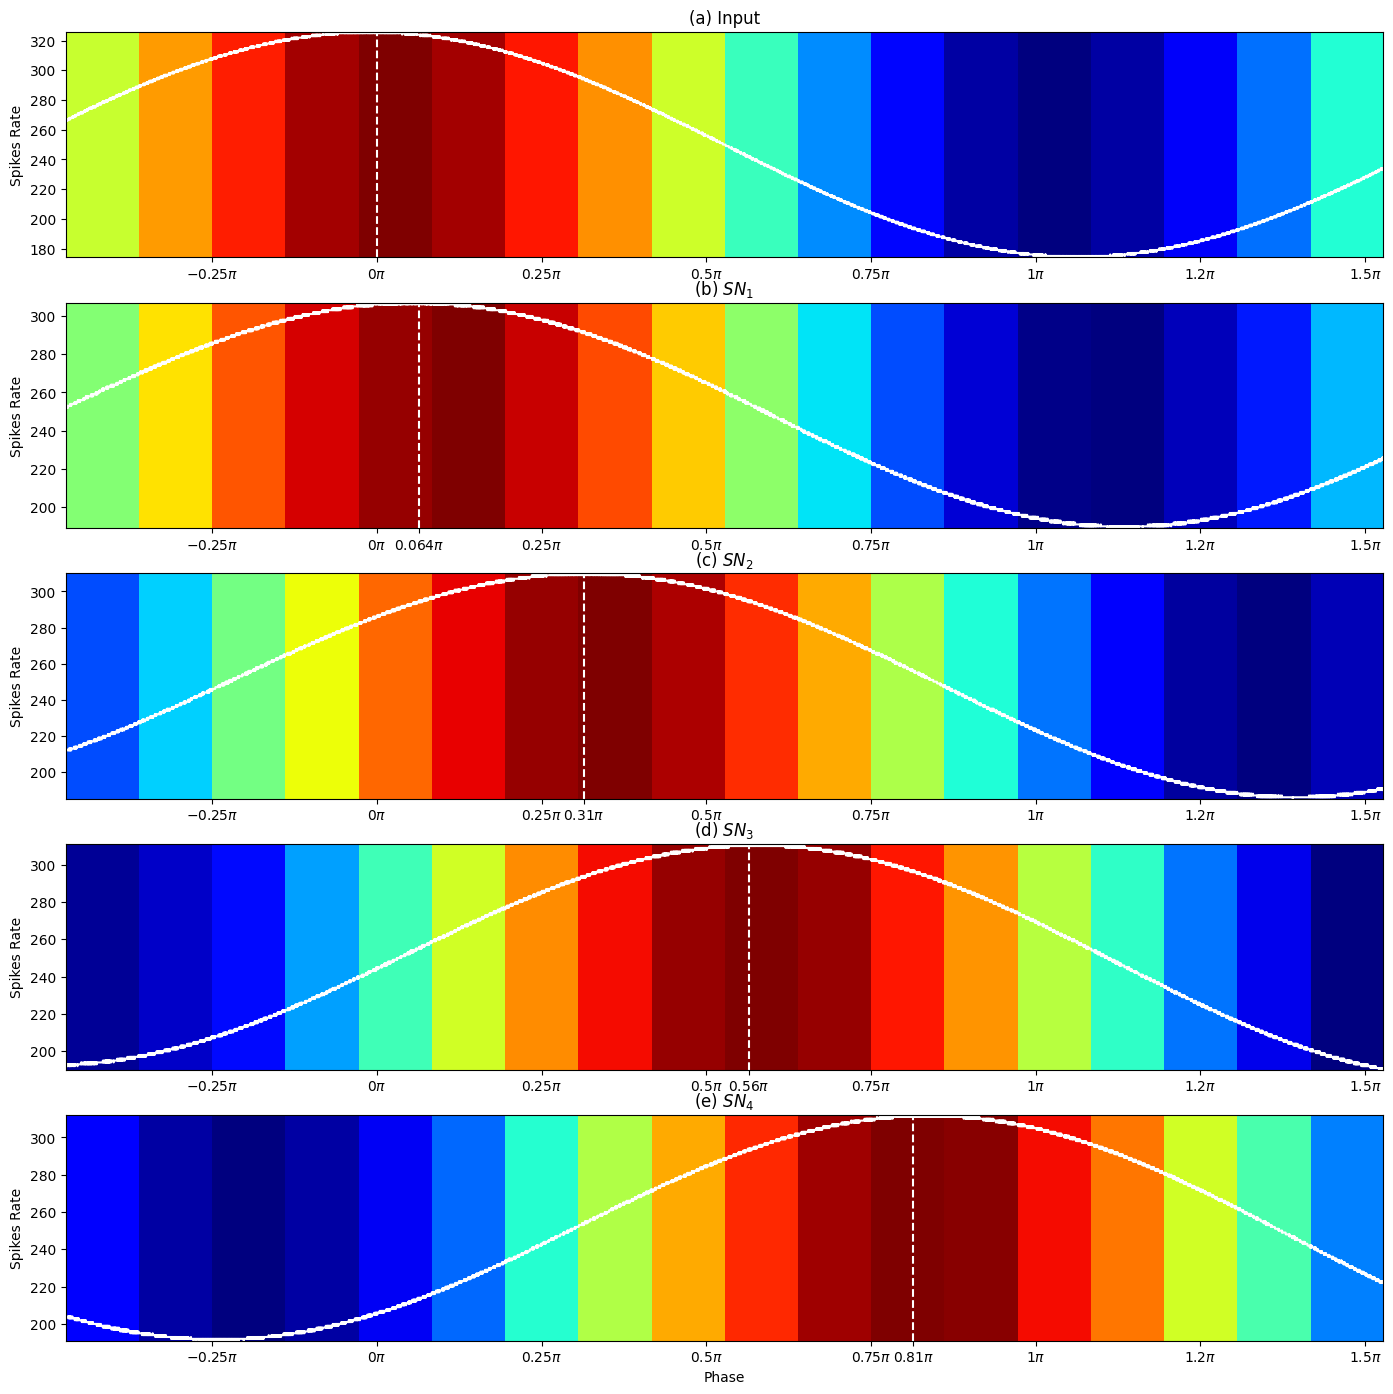

In [9]:
fig, axs = plt.subplots(5, 1, figsize=(17, 17))
phase_shift = [11.6, 45, 45, 45]
labels = ['input'] + [f'shift by {i}' for i in phase_shift]
abc_order = ['a', 'b', 'c', 'd', 'e']
for i in neurons_log_spikes:
    spikes_window_size = 500
    if i == 0:
        output_neuron = resonator0.neurons[i]
    else:
        output_neuron = my_resonator.neurons[i]
    y_events = output_neuron.out_spikes()
#     y_events = y_events[(y_events > (duration - (3/signal_freq)) * clk_freq) & (y_events < (duration - (2/signal_freq)) * clk_freq)]
    first_phase = 4
    n_phases = 1
    y_events = y_events[(y_events > (first_phase/signal_freq) * clk_freq) & (y_events < ((first_phase + n_phases)/signal_freq) * clk_freq)]
    y_events -= y_events[0]
    y_spikes = np.zeros(int(clk_freq / signal_freq) * n_phases)
    y_spikes[y_events] = 1
    y_spikes_rollsum = np.convolve(y_spikes, np.ones(spikes_window_size, dtype=int), 'valid')

    max_spikes = np.max(y_spikes_rollsum)
    min_spikes = np.min(y_spikes_rollsum)

    bin_window = 400
    pdm = y_spikes[:-(len(y_spikes)%bin_window)]
    pdm = pdm.reshape(-1, bin_window).sum(axis=1)
    pdm = np.array([pdm])
    ax = axs[i]
    if i == 0:
        ax.set_title(f'({abc_order[i]}) Input')
    else:
        ax.set_title(f'({abc_order[i]})' + r' $SN_{i}$'.format(i=i))
    pivot = 85
    im = ax.imshow(pdm, aspect='auto',
               cmap='jet', origin='lower',
               extent=[0-pivot, n_phases*360-pivot, min_spikes, max_spikes],
               )
    if i == 0:
        ax.vlines(0, min_spikes, max_spikes, color='w', linestyle='--')
        x_ticks = np.array([-45, 0, 45, 90, 135, 180, 225, 270])
        ax.set_xticks(x_ticks)
        x_labels_ticks = [r"$" + format(t/180, ".2g")+ r"\pi$" for t in x_ticks]
        ax.set_xticklabels(x_labels_ticks)
    else:
        peak = sum(phase_shift[:i])
        ax.vlines(peak, min_spikes, max_spikes, color='w', linestyle='--')
        x_ticks = np.array(sorted([-45, 0, 45, 90, 135, 180, 225, 270]+ [peak]))
        ax.set_xticks(x_ticks)
        x_labels_ticks = [r"$" + format(t/180, ".2g")+ r"\pi$" for t in x_ticks]
        ax.set_xticklabels(x_labels_ticks)
    # fig.colorbar(im, ax=ax)
    ax.plot(np.linspace(0-pivot, n_phases*360-pivot, len(y_spikes_rollsum)), y_spikes_rollsum, color='w')
    ax.set_ylabel('Spikes Rate')


    if i == 4:
        ax.set_xlabel('Phase')

plt.show()

## 1 Neuron

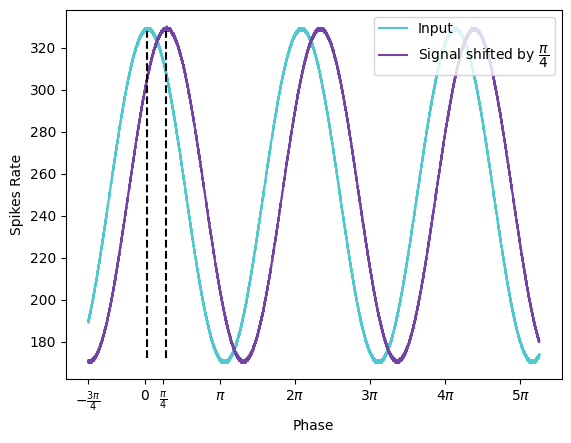

In [67]:

def neuron_output(neuron, rolling_window, duration, signal_freq, shift_degrees=0, cycles=5):
    y_events = neuron.out_spikes()
    samples_per_cycle =  clk_freq / signal_freq
    samples_per_degree = samples_per_cycle/360
    shift_samples = int(shift_degrees*samples_per_degree)
    y_events = y_events[
        (y_events > (duration - ((2+cycles)/signal_freq)) * clk_freq + shift_samples) &
        (y_events < (duration - (2/signal_freq)) * clk_freq + shift_samples)
    ]
    if len(y_events) == 0:
        raise ValueError("No spikes were emit.")
    y_events -= y_events[0]
    y_spikes = np.zeros(int(cycles/signal_freq * clk_freq) + 1)
    y_spikes[y_events] = 1
    y_spikes_rollsum = np.convolve(y_spikes, np.ones(rolling_window, dtype=int), 'valid')
    return y_spikes_rollsum


shift_network = simple_resonator(freq0=resonator_freq, clk_freq=clk_freq, lf=4,
                              thetas=[-9.896, -21.483, -20.349, -20.591],
                              weights=[53.846, 34.091, 42.951, 40.759, 41.223])

shift_network.log_out_spikes(0)
shift_network.log_out_spikes(1)
shift_network.log_out_spikes(2)
shift_network.log_out_spikes(3)
shift_network.log_out_spikes(4)

spikes_window_size = 500
cycles = 3
shift_network.input_full_data(sine_wave)
phase_shift = -45
input_encoded = neuron_output(shift_network.neurons[2], spikes_window_size, duration, resonator_freq, cycles=cycles)
signal_shifted = neuron_output(shift_network.neurons[3], spikes_window_size, duration, resonator_freq, cycles=cycles)
# ground_truth = neuron_output(shift_network.neurons[0], spikes_window_size, duration, resonator_freq, phase_shift, cycles=cycles)
x_axis = np.linspace(-135, 360*cycles-135, len(input_encoded))
plt.plot(x_axis, input_encoded, label=f'Input', color='#50C9CE')
# plt.plot(ground_truth, label=f'input shifted')
plt.plot(x_axis, signal_shifted, label=r'Signal shifted by $\dfrac{\pi}{4}$', color='#7143A3')

x_ticks = np.array([-135, 0, 45, 180, 360, 540, 720, 900, 1080])
# x_labels_ticks = [r"$" + format(t/180, ".2g")+ r"\pi$" for t in x_ticks]
x_labels_ticks = [r'$-\frac{3\pi}{4}$', r'$0$', r'$\frac{\pi}{4}$', '$\pi$'] + [r"$" + format(t/180, ".2g")+ r"\pi$" for t in x_ticks[4:]]
plt.xticks(x_ticks, labels=x_labels_ticks)
peak = np.argmax(input_encoded)
peak = x_axis[peak]+7
plt.vlines(peak, 172, 328, color='k', linestyle='--')
plt.vlines(peak+45, 172, 328, color='k', linestyle='--')

plt.xlabel('Phase')
plt.ylabel('Spikes Rate')
plt.legend(loc='upper right')


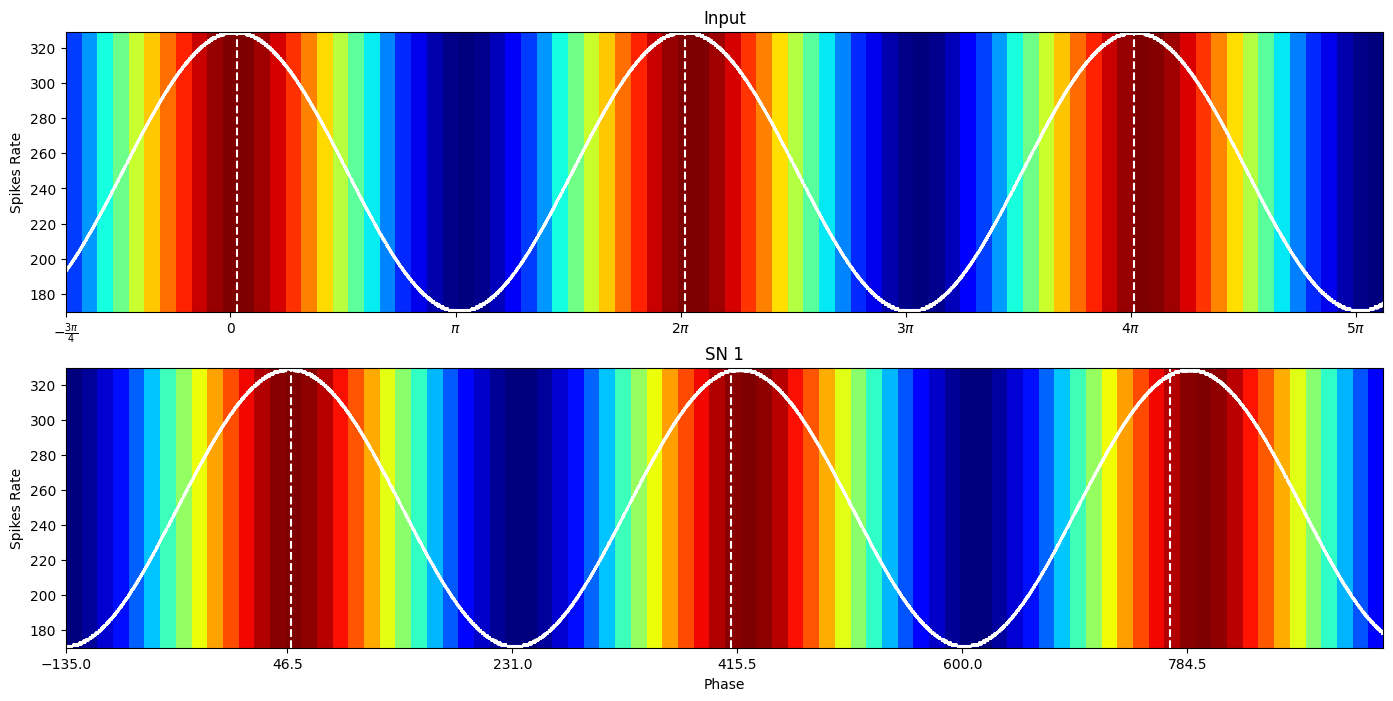

In [99]:
# spikes_window_size = clk_freq // 50
# spikes_window_size = 250
fig, axs = plt.subplots(2, 1, figsize=(17, 8))
phase_shift = [5, 45]
cycles = 3
freq0 = 212.2
spikes_window_size = 500

for i in [0, 1]:
    y_spikes = neuron_output(shift_network.neurons[i+2], spikes_window_size, duration, freq0, cycles=cycles)

    max_spikes = np.max(y_spikes)
    min_spikes = np.min(y_spikes)

    bin_window = 250
    pdm = y_spikes[:-(len(y_spikes)%bin_window)]
    pdm = pdm.reshape(-1, bin_window).sum(axis=1)
    pdm = np.array([pdm])
    ax = axs[i]
    if i == 0:
        ax.set_title(f'Input')
    else:
        ax.set_title(f'SN {i}')
    pivot = 135
    im = ax.imshow(pdm, aspect='auto',
               cmap='jet', origin='lower',
               extent=[0-pivot, 360*cycles-pivot, min_spikes, max_spikes],
               )
    ax.plot(np.linspace(0-pivot, 360*cycles-pivot, len(y_spikes)), y_spikes, color='w')
    if i == 0:
        for j in range(0, 3):
            peak = sum(phase_shift[:i+1]) + j*368
            ax.vlines(peak, min_spikes, max_spikes, color='w', linestyle='--')
        x_ticks = np.array([-135] + np.arange(0, 930, 184.5).tolist())
        ax.set_xticks(x_ticks)
        x_labels_ticks = [r'$-\frac{3\pi}{4}$', r'$0$', '$\pi$'] + [r"$" + format(t/180, ".2g")+ r"\pi$" for t in range(360, 930, 180)]
        ax.set_xticklabels(labels=x_labels_ticks)
    else:
        for j in range(0, 3):
            peak = sum(phase_shift[:i+1]) + j*360
            ax.vlines(peak, min_spikes, max_spikes, color='w', linestyle='--')
        x_ticks = np.array([-135] + np.arange(46.5, 930, 184.5).tolist())
        ax.set_xticks(x_ticks)
        # x_labels_ticks = [r'$-\frac{3\pi}{4}$', r'$-\frac{\pi}{4}$', '$\pi$'] + [r"$" + format(t/180, ".2g")+ r"\pi$" for t in range(360, 930, 180)]
        # ax.set_xticklabels(labels=x_labels_ticks)
    ax.set_ylabel('Spikes Rate')
    if i == 1:
        ax.set_xlabel('Phase')

plt.show()

## Depict Resonator

In [38]:
from snn.resonator import create_chirp_signal, create_base_resonator
from numba import njit


@njit
def test_frequency(network, test_size=10_000_000, start_freq=0, step=1 / 200000, clk_freq=1536000):
    batch_size = 50_000
    shift = 0
    while test_size > 0:
        sine_size = min(batch_size, test_size)
        sine_wave, freqs = create_chirp_signal(sine_size, clk_freq, start_freq, step, shift)

        network.input_full_data(sine_wave)

        shift = freqs[-1]
        start_freq += sine_size * step
        test_size -= sine_size

def custom_resonator_output_spikes(
        resonator,
        freq0,
        clk_freq,
        sample_rate=1,
        step = None,
        save_figure=False,
        path=None,
        plot=True,
        label=None
):
    resonator.log_out_spikes(-1)
    start_freq = freq0/2
    spectrum = freq0
    step = step or 1 / clk_freq / sample_rate
    test_size = int(spectrum / step)
    spikes_neuron = resonator.neurons[-1]

    spikes_neuron.membrane_sample_max_window = np.zeros(1).astype('float32')
    test_resonator_on_chirp(
        resonator,
        start_freq=start_freq,
        step=step,
        test_size=test_size,
        clk_freq=clk_freq
   )

    events = spikes_neuron.out_spikes()
    y_spikes = np.zeros(events[-1] + 1)
    y_spikes[events] = 1

    if path is not None:
        np.savez_compressed(path, spikes=y_spikes)

    spikes_window_size = 500
    y_spikes = np.convolve(y_spikes, np.ones(spikes_window_size, dtype=int), 'valid')
    x = np.linspace(start_freq, start_freq + spectrum, len(y_spikes))
    plt.title(f'spikes in window of {spikes_window_size} freq: {freq0}')
    plt.plot(x, y_spikes, label=label)
    if save_figure:
        plt.savefig(f'../filters/clk_{clk_freq}/figures/f_{freq0:.3f}.PNG', bbox_inches='tight')
        plt.close()
    elif plot:
        plt.show()


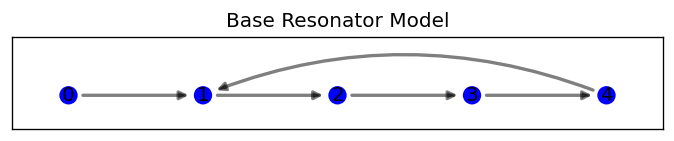

In [5]:

freq0 = 5.9
clk_freq = 76800
resonator = create_base_resonator(freq0=f'{freq0:.3f}', clk_freq=clk_freq)
plot_network(resonator)
plt.title('Base Resonator Model')
None

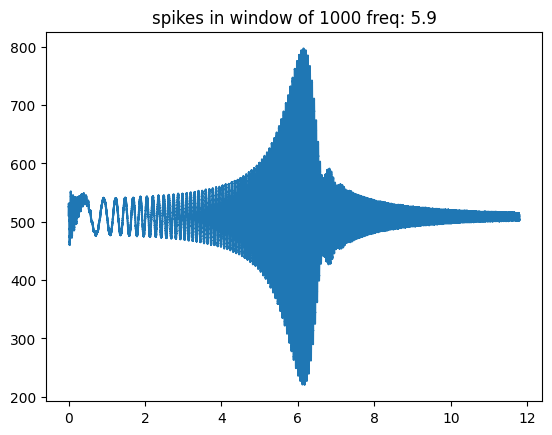

In [586]:
custom_resonator_output_spikes(resonator, freq0, clk_freq, sample_rate=3)

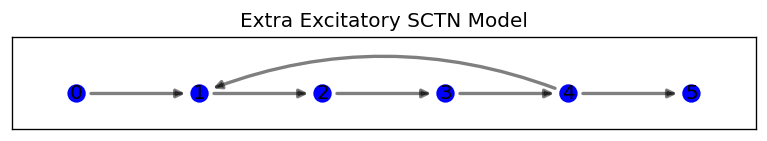

In [9]:
resonator = create_excitatory_resonator(freq0=f'{freq0:.3f}', clk_freq=clk_freq)
plot_network(resonator)
plt.title('Extra Excitatory SCTN Model')
None

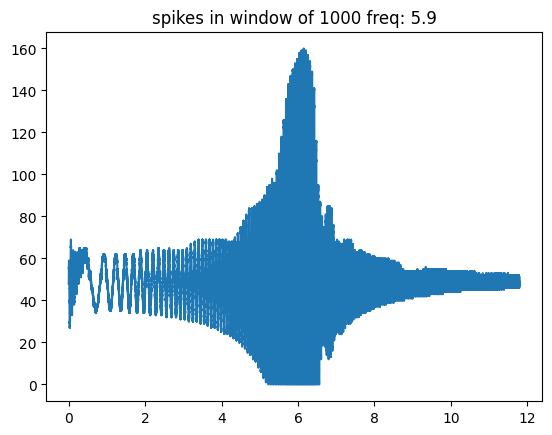

In [585]:
custom_resonator_output_spikes(resonator, freq0, clk_freq, sample_rate=3)

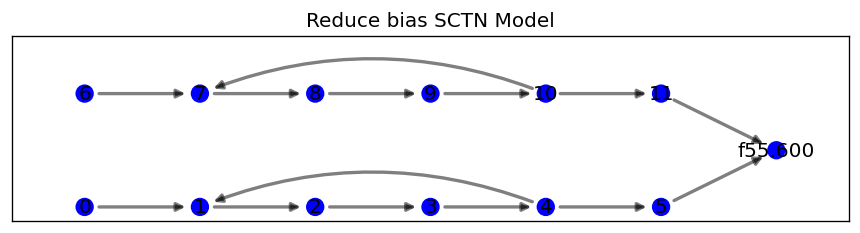

In [15]:
clk_freq = 614400
freq0 = 55.600
resonator = create_excitatory_inhibitory_resonator(freq0=f'{freq0:.3f}', clk_freq=clk_freq)
plot_network(resonator)
plt.title('Reduce bias SCTN Model')
None

1.1 110.71648215088372
1.3 130.58867125488848
1.6 160.83025828233633
1.9 190.9859317102744


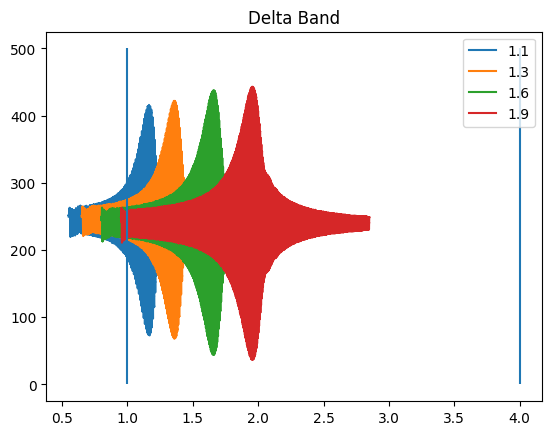

In [39]:
from snn.resonator import trained_resonator, freq_of_resonator
import numpy as np

bands = {
    'Delta': (1, 4),
    # 'Theta': (4, 8),
    # 'Alpha': (8, 14),
    # 'Beta': (14, 32),
    # 'Gamma': (32, 60),
}
resonators_freqs = np.concatenate([np.linspace(start, stop, 11)[1:-1] for start, stop in bands.values()])
clk_resonators = {
    # 15360: resonators_freqs[resonators_freqs < 10].tolist(),
    15360: [1.1, 1.3, 1.6, 1.9, ]#2.2, 2.5, 2.88, 3.05, 3.39, 3.7, 4.12, 4.62, 5.09, 5.45, 5.87, 6.36, 6.8, 7.6, 8.6, 9.54],
    # 153600: [10.5, 11.5, 12.8, 15.8, 17.5, 19.4, 22.0, 24.8, 28.4, 30.5, 34.7, 37.2, 40.2, 43.2, 47.7, 52.6, 57.2]
}
for band_name, (band0, band1) in bands.items():
    for clk_freq, freqs in clk_resonators.items():
        for freq0 in freqs:
            if not (band0 < freq0 < band1):
                continue
            resonator = trained_resonator(
                freq0=float(freq0),
                filters_folder='filters4_xi0'
            )
            print(freq0, freq_of_resonator(1536000, resonator.neurons[1].leakage_factor, resonator.neurons[1].leakage_period))
            # resonator = create_excitatory_inhibitory_resonator(freq0=f'{freq0:.3f}', clk_freq=clk_freq)
            custom_resonator_output_spikes(resonator, freq0, clk_freq, step=1 / 1536000, plot=False, label=freq0)
    plt.vlines(band0, 0, 500)
    plt.vlines(band1, 0, 500)
    plt.title(f"{band_name} Band")
    plt.legend()
    plt.show()
    break

In [7]:
print(sorted(list({110, 130, 160, 190, 221, 250, 288, 305, 339, 372, 412, 462, 509, 545, 587, 636, 694, 763, 898, 105, 115, 128, 159, 166, 195, 221, 250, 288, 305, 347, 372, 402, 436, 477, 526, 587,})))

[105, 110, 115, 128, 130, 159, 160, 166, 190, 195, 221, 250, 288, 305, 339, 347, 372, 402, 412, 436, 462, 477, 509, 526, 545, 587, 636, 694, 763, 898]


### Check Resonator 104 Amplitudes!

Text(0.5, 1.0, 'Base Resonator Model')

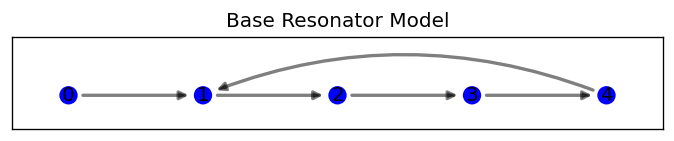

In [14]:
freq0 = 104
clk_freq = 1536000
resonator = create_base_resonator(freq0=f'{freq0}', clk_freq=clk_freq)
plot_network(resonator)
plt.title('Base Resonator Model')

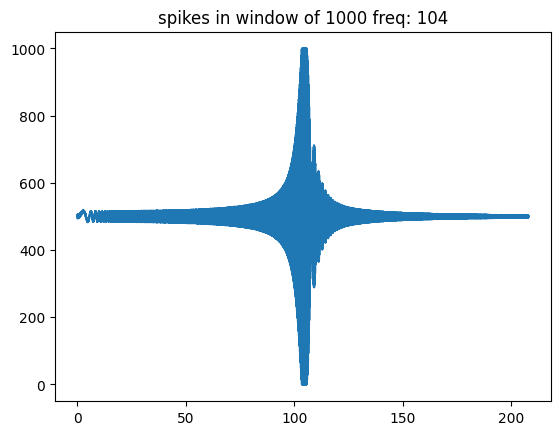

In [19]:
resonator.neurons[-1].forget_logs()
custom_resonator_output_spikes(resonator, freq0, clk_freq, sample_rate=1, step=1/100000)

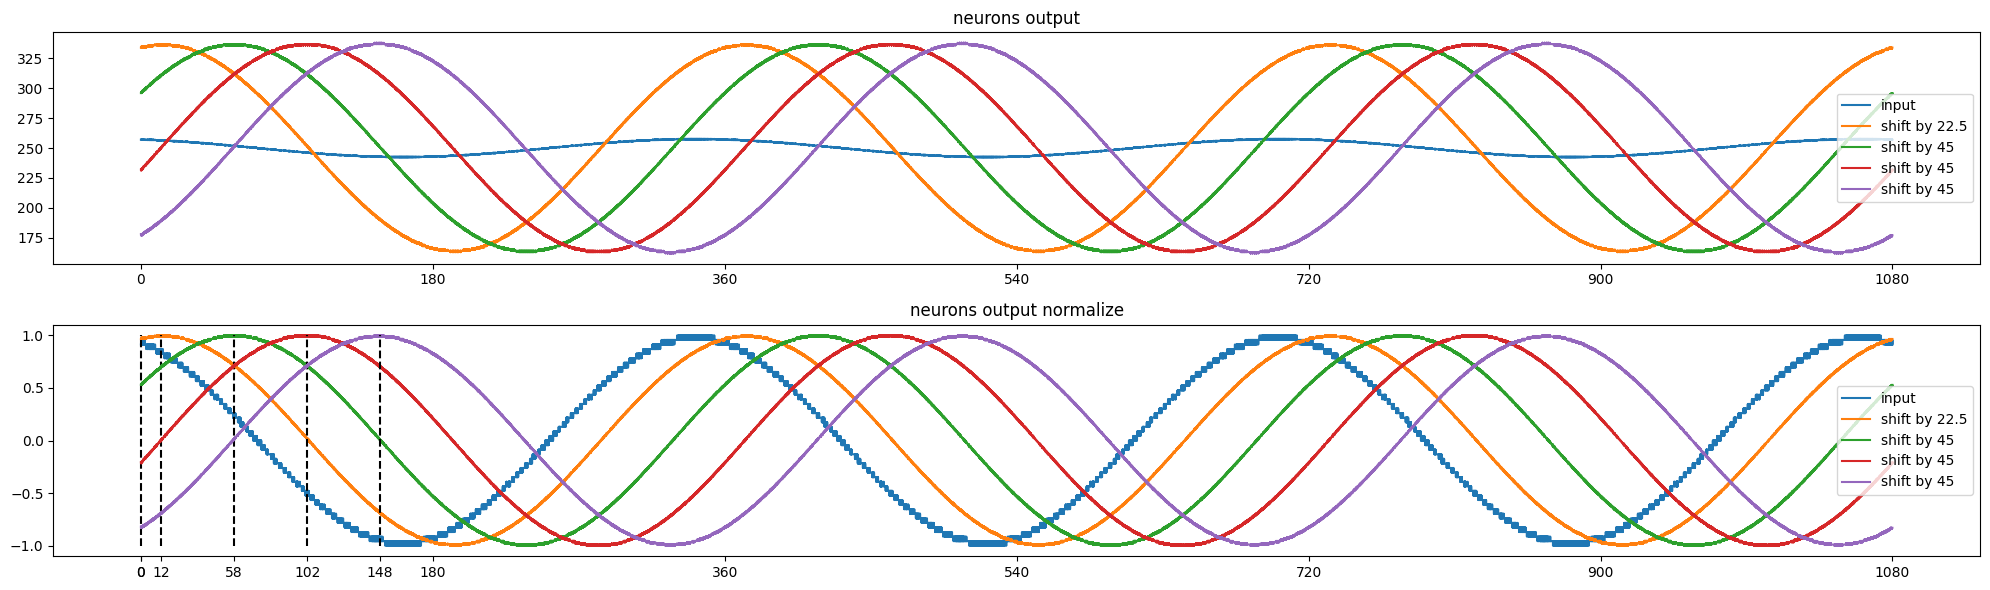

In [51]:
from snn.resonator import trained_resonator, freq_of_resonator

duration = 5

# resonator_freq = '104'
resonator_freq = 104
clk_freq = 1536000
my_resonator = simple_resonator(
        resonator_freq,
        clk_freq,
        5,
        [-1, -5, -5, -5],
        [11, 9, 10, 10, 10],
)

signal_freq = 104
cycles = 5

neurons_log_spikes = range(5)
for i in neurons_log_spikes:
    my_resonator.log_out_spikes(i)

spectrum = duration

x = np.linspace(0, spectrum, int(duration * clk_freq))
t = x * 2 * np.pi * signal_freq + np.pi/2
sine_wave = np.sin(t)

my_resonator.input_full_data(sine_wave)

spikes_window_size = 500
# fig, axs = plt.subplots(3, 1, figsize=(20, 8))
fig, axs = plt.subplots(2, 1, figsize=(20, 6))
labels0 = [
    'input',
    'shift by 22.5',
    'shift by 45',
    'shift by 45',
    'shift by 45',
]

phase_shift = np.cumsum([0.0] + [12.5] + [45.0] * 3).tolist()
for i in neurons_log_spikes:
    if i == 0:
        spikes_window_size = 1500
    else:
        spikes_window_size = 500
    output_neuron = my_resonator.neurons[i]
    y_events = output_neuron.out_spikes()
    y_events = y_events[(y_events > (duration - ((7+cycles)/signal_freq)) * clk_freq) & (y_events < (duration - (7/signal_freq)) * clk_freq)]
    plt_cycles = cycles - 2
    y_events -= y_events[0]
    y_spikes = np.zeros(int(cycles * clk_freq / signal_freq + 1))
    y_spikes[y_events] = 1
    y_spikes_rollsum = np.convolve(y_spikes, np.ones(spikes_window_size, dtype=int), 'valid')[:int(plt_cycles * clk_freq / signal_freq)]
    max_spikes = np.max(y_spikes_rollsum)
    min_spikes = np.min(y_spikes_rollsum)
    normalize_roll = (y_spikes_rollsum-min_spikes)/(max_spikes - min_spikes)
    normalize_roll = normalize_roll*2-1
    pivot = 0

    if i == 0:
        # axs[2].plot(np.linspace(0 - pivot, cycles * 360 - pivot, len(normalize_roll)), normalize_roll, label=labels0[i])
        y_spikes_rollsum /= 3
    axs[0].plot(np.linspace(0 - pivot, plt_cycles * 360 - pivot, len(y_spikes_rollsum)), y_spikes_rollsum, label=labels0[i])
    axs[1].plot(np.linspace(0 - pivot, plt_cycles * 360 - pivot, len(normalize_roll)), normalize_roll, label=labels0[i])

    axs[1].vlines(phase_shift[i], -1, 1, color='k', linestyle='--')
axs[0].set_xticks(sorted([0, 180, 360, 540, 720, 900, 1080]))
axs[1].set_xticks(sorted([0, 180, 360, 540, 720, 900, 1080] + phase_shift))
    # if i == 4:
    #     axs[2].plot(np.linspace(0 - pivot, cycles * 360 - pivot, len(normalize_roll)), normalize_roll, label=f'last neuron', color='tab:purple')

axs[0].set_title('neurons output')
axs[1].set_title('neurons output normalize')
# axs[2].set_title('first and last neuron output')
axs[0].legend(loc='right')
axs[1].legend(loc='right')
# axs[2].legend(loc='right')
plt.tight_layout()
plt.show()

In [52]:
phase_shift

[0.0, 12.5, 57.5, 102.5, 147.5]

In [116]:
output_neuron = my_resonator.neurons[0]
y_events = output_neuron.out_spikes()
y_events = y_events[(y_events > (duration - (10/signal_freq)) * clk_freq) & (y_events < (duration - (5/signal_freq)) * clk_freq)]
y_events -= y_events[0]
y_spikes = np.zeros(int(5/signal_freq * clk_freq) + 1)
y_spikes[y_events] = 1
y_spikes_rollsum = np.convolve(y_spikes, np.ones(spikes_window_size, dtype=int), 'valid')
max_spikes = np.max(y_spikes_rollsum)
min_spikes = np.min(y_spikes_rollsum)
normalize_roll0 = (y_spikes_rollsum-min_spikes)/(max_spikes - min_spikes)
normalize_roll0 = normalize_roll0*2-1

output_neuron = my_resonator.neurons[-1]
y_events = output_neuron.out_spikes()
y_events = y_events[(y_events > (duration - (10/signal_freq)) * clk_freq) & (y_events < (duration - (5/signal_freq)) * clk_freq)]
y_events -= y_events[0]
y_spikes = np.zeros(int(5/signal_freq * clk_freq) + 1)
# y_spikes = np.zeros(y_events[-1] + 1)
y_spikes[y_events] = 1
y_spikes_rollsum = np.convolve(y_spikes, np.ones(spikes_window_size, dtype=int), 'valid')
max_spikes = np.max(y_spikes_rollsum)
min_spikes = np.min(y_spikes_rollsum)
normalize_roll1 = (y_spikes_rollsum-min_spikes)/(max_spikes - min_spikes)
normalize_roll1 = normalize_roll1*2-1
signal_length = min(len(normalize_roll1), len(normalize_roll0))
print(f'mse {np.sum((normalize_roll1[:signal_length] + normalize_roll0[:signal_length]) ** 2)/signal_length}')

mse 0.0001319395965263285


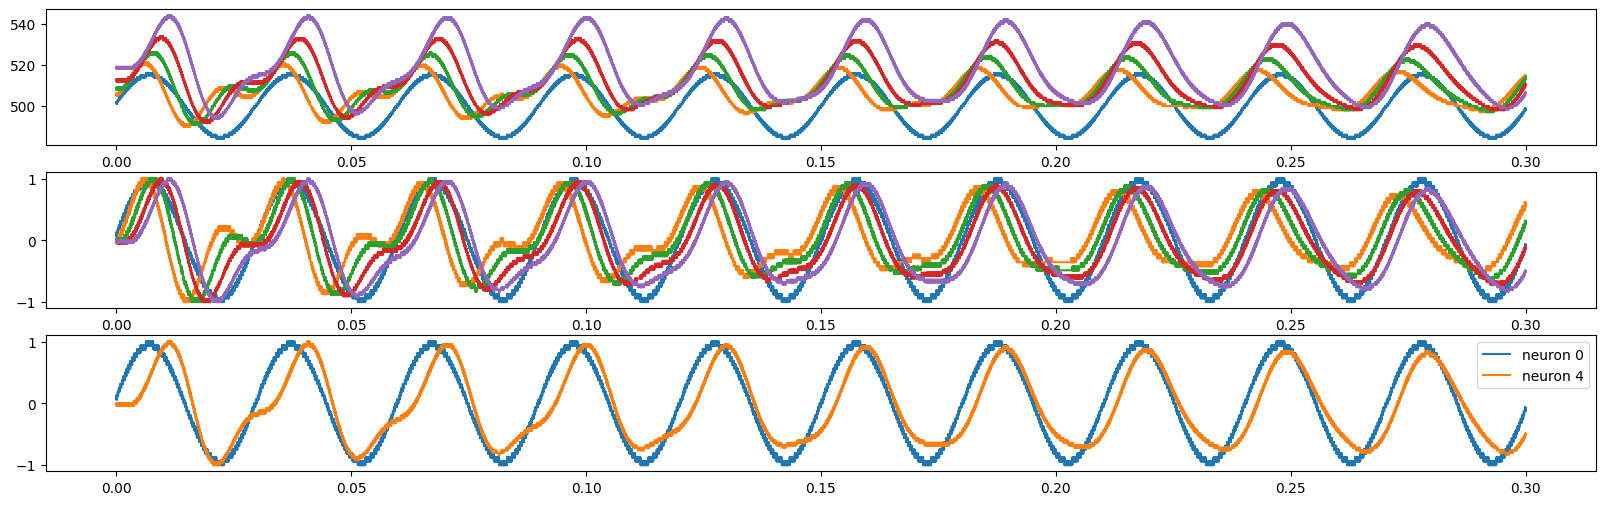

In [59]:
duration = .3

resonator_freq = '104'
clk_freq = 1536000
my_resonator = create_base_resonator(freq0=resonator_freq, clk_freq=clk_freq)

signal_freq = 50

neurons_log_spikes = range(5)
for i in neurons_log_spikes:
    my_resonator.log_out_spikes(i)

spectrum = duration

x = np.linspace(0, spectrum, int(duration * clk_freq))
t = x * 2 * np.pi * signal_freq
sine_wave = np.sin(t)

my_resonator.input_full_data(np.zeros(clk_freq * 1))
for i in neurons_log_spikes:
    output_neuron = my_resonator.neurons[i]
    output_neuron.forget_logs()
my_resonator.input_full_data(sine_wave)

spikes_window_size = 1000

fig, axs = plt.subplots(3, 1, figsize=(20, 6))
for i in neurons_log_spikes:
    output_neuron = my_resonator.neurons[i]
    y_events = output_neuron.out_spikes()
    y_events = y_events[(y_events > (duration - (15/signal_freq)) * clk_freq) & (y_events < (duration - (5/signal_freq)) * clk_freq)]
    y_events -= y_events[0]
    y_spikes = np.zeros(y_events[-1] + 1)
    y_spikes[y_events] = 1
    y_spikes_rollsum = np.convolve(y_spikes, np.ones(spikes_window_size, dtype=int), 'valid')
    max_spikes = np.max(y_spikes_rollsum)
    min_spikes = np.min(y_spikes_rollsum)
    normalize_roll = (y_spikes_rollsum-min_spikes)/(max_spikes - min_spikes)
    normalize_roll = normalize_roll*2-1

    axs[0].plot(np.linspace(0, duration, len(y_spikes_rollsum)), y_spikes_rollsum, label=f'neuron {i}')
    axs[1].plot(np.linspace(0, duration, len(normalize_roll)), normalize_roll, label=f'neuron {i}')
    if i == 0 or i == 4:
        axs[2].plot(np.linspace(0, duration, len(normalize_roll)), normalize_roll, label=f'neuron {i}')

plt.legend()
plt.show()